<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Class 4: Policy Gradient and Actor-Critic Algorithms</div>

1. <a href="#policies">Learning parametric policies</a>
2. <a href="#PG">Policy gradient methods</a>
3. <a href="#objective">Objective function</a>
4. <a href="#theorem">The Policy Gradient theorem</a>
6. <a href="#ac">Actor-Critic methods</a>
7. <a href="#pi">The link with Policy Iteration</a>
8. <a href="#deep">Deep Actor-Critic algorithms and references</a>
9. <a href="#practice">Practice</a>
    1. <a href="#why">Why use Actor-Critic algorithms?</a>
    2. <a href="#environments">Environments</a>
    3. <a href="#ddpg">Deep Deterministic policy gradient</a>
    4. <a href="#sac">Soft-Actor Critic</a>

# <div id="policies"></div> Learning parametric policies

**Bottomline question:**<br>
The previous classes have focussed on *action-value methods*; they aimed at estimating $Q^*$ in order to deduce $\pi^*$. Could we directly optimize $\pi$?

Suppose we have a policy $\pi_\theta$ parameterized by a vector $\theta$. Our goal is to find the parameter $\theta^*$ corresponding to $\pi^*$.

Remarks:
- $\pi_\theta$ might not be able to represent $\pi^*$. We will take a shortcut and call $\pi^*$ the best policy among the $\pi_\theta$ ones.
- for discrete state and action space, the tabular policy representation is a special case of policy parameterization.
- policy parameterization is a (possibly useful) way of introducing prior knowledge on the set of the desired policies.
- the optimal deterministic policies might not belong to the policy subspace of $\pi_\theta$, thus it makes sense to consider stochastic policies for $\pi_\theta$.
- for problems with significant policy approximation, the best approximate policy (among $\pi_\theta$ ones) may very well be stochastic.
- it makes even more sense to consider stochastic policies that it opens the family of environments that we can tackle, like partially observable MDPs or multi-player games.

For stochastic policies, we shall write $\pi_\theta(a|s)$.

In the remainder of the class, we will assume that $\pi_\theta$ is differentiable with respect to $\theta$.

To directly optimize $\theta$ we need a criterion $J(\theta)$.

# <div id="PG"></div>Policy gradient methods

Suppose now we define some performance metric $J(\pi_\theta) = J(\theta)$. If $J$ is differentiable and a stochastic estimate $\nabla_\theta J(\theta)$ of the gradient is available, then we can define the gradient ascent update procedure:
$$\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta).$$

We will call **policy gradient methods** all methods that follow such a procedure (whether or not they also learn a value function or not).

Remarks: 
- Note that $J$ is a more general criterion that might differ from $Q$ in the definition above (even though it seems reasonable to assume both should be related). For example, $J$ could be defined as the value of a starting state (or a distribution of starting states) in episodic cases, or as the undiscounted reward over a certain horizon, or as the average reward.
- Why is it interesting to look at policy gradient methods? Because for continuous actions there is no maximization step ($\max_a Q(s,a)$) during evaluation but only a call to $\pi_\theta(s)$ (or a draw from $\pi_\theta(a|s)$). This makes Policy Gradient a method of choice for continuous actions domains (especially common in Robotics).
- When do policy gradient approaches outperform value-based ones? It's hard to give a precise criterion; it really depends on the problem. One thing that comes into play is how easy it is to approximate the optimal policy or the optimal value function. If one is simpler than the other (by "simpler", we mean "it is easier to find a parameterization whose spanned function space almost includes the function to approximate"), then it is a good heuristic to try to approximate it. But this criterion might itself be hard to assess.


# Notations

- We consider probability density functions $p(X)$ for all random variables $X$.
- For a policy $\pi_\theta$ and a random variable $X$ we write indifferently $p(X|\pi_\theta) = p(X|\theta)$.
- A trajectory is noted $\tau = (s_t,a_t)_{t\in [0,\infty]}$.
- The state random variable at step $t$ is $S_t$ and its law's density is $p_t(s)$.
- The action random variable at step $t$ is $A_t$.

# <div id="objective"></div> Rewriting the policy optimization's objective function.

Although it is not strictly necessary for the following sections, let us play a bit with the policy optimization's objective function.

We defined the policy optimization's objective as:  
$$J(\pi) = \mathbb{E}_{s \sim p_0} \left[ V^{\pi} (s) \right].$$
Or equivalently:  
$$J(\pi) = \mathbb{E}_{(s_i,a_i)_{i \in [0,\infty]}} \left[ \sum_{t=0}^\infty \gamma^t r(s_t,a_t)  | \pi \right].$$
We can switch the sum and the expectation and get:  
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \mathbb{E}_{(s_i,a_i)_{i \in [0,\infty]}} \left[ r(s_t,a_t)  | \pi \right]$$
But $\mathbb{E}_{(s_i,a_i)_{i \in [0,\infty]}} \left[ r(s_t,a_t)  | \pi \right] = \mathbb{E}_{s_t,a_t} \left[ r(s_t,a_t)  | \pi \right]$. So:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \mathbb{E}_{s_t,a_t} \left[ r(s_t,a_t)  | \pi \right].$$
Now let's introduce the density of $(s_t,a_t)$:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \int_S \int_A r(s_t,a_t) p(s_t,a_t|\pi) ds_t da_t.$$
But $p(s_t,a_t|\pi) = p(s_t|\pi) p(a_t|s_t,\pi)$. By definition, $p(s_t|\pi) = p_t(s|\pi)$ and $p(a_t=a|s_t=s,\pi) = \pi(a|s)$. So:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \int_S \int_A r(s,a) p_t(s|\pi) \pi(a|s) ds da.$$
Let us isolate the terms that concern only states:
$$J(\pi) = \int_S \left[ \int_A r(s,a) \pi(a|s) da \right] \sum_{t=0}^\infty \gamma^t p_t(s|\pi) ds.$$
Let's note $\rho^\pi(s) = \sum_{t=0}^\infty \gamma^t p_t(s|\pi)$. We will call this quantity the density of the *improper state distribution under policy $\pi$*. Then we have:
$$J(\pi) = \int_S \left[ \int_A r(s,a) \pi (a|s) da \right] \rho^\pi(s) ds.$$
And so finally:
$$J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ r(s,a) \right].$$

In plain words, the value of a policy $\pi$ is the average value of the rewards when states are sampled according to $\rho^\pi$ and actions are sampled according to $\pi$.

# <div id="theorem"></div>The Policy Gradient theorem

The crucial problem of computing $\nabla_\theta J(\theta)$ lies in the fact that when $\theta$ changes, both $\pi$ and $\rho^\pi$ change in turn. So there seems to be no straighforward way of evaluating this gradient. One could fall back on a *finite differences* approach to estimating this gradient, but this would require trying out a series of increments $\Delta \theta$ which quickly becomes impractical (because the increment size is hard to tune, especially in stochastic systems, and also because of the sample inefficiency of the approach).

The key result of this class is that one can express the gradient of $J(\theta)$ as directly proportional to the value of $Q^\pi$ and the gradient of $\pi$:
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right]$$

The proof of this result is simple but a bit tedious. We can however give the general intuition. Let's consider trajectories $\tau = (s_0,a_0,r_0,...)$ drawn according to $\pi$ from the starting state. Each of these trajectories has an overall payoff of $G(\tau) = \sum_t \gamma^t r_t$ and is drawn with probability density $p(\tau|\theta)$. Then the objective function can be written:
\begin{align}
J(\theta) &= \mathbb{E}_\tau \left[ G(\tau) | \theta \right]\\
 &= \int G(\tau) p(\tau | \theta) d\tau
\end{align}

So the objective function's gradient is:
\begin{align}
\nabla_\theta J(\theta) &= \nabla_\theta \int G(\tau) p(\tau|\theta) d\tau,\\
 &= \int G(\tau) \nabla_\theta p(\tau|\theta) d\tau,\\
 &= \int G(\tau) p(\tau|\theta) \frac{\nabla_\theta p(\tau|\theta)}{p(\tau|\theta)} d\tau,\\
 &= \mathbb{E}_\tau \left[ G(\tau) \nabla_\theta \log p(\tau|\theta) \right].
\end{align}

Let us study a little the $\nabla_\theta \log p(\tau|\theta)$ term along a series of remarks.

**Remark 1**: law of $s_{t+1},a_{t+1}$ given the policy and history.  
One has $p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) p(a_{t+1} | s_{t+1}, (s_i,a_i)_{i \in [0,t]}, \theta)$.  
But the transition model is Markovian, so $p(s_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | s_t, a_t)$.  
And the law of $a_{t+1}$ is given by the policy, so $p(a_{t+1} | s_{t+1}, (s_i,a_i)_{i \in [0,t]}, \theta) = \pi_\theta(a_{t+1}|s_{t+1})$.  
Consequently:
$$p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | s_t, a_t) \pi_\theta(a_{t+1}|s_{t+1}).$$

**Remark 2**: probability density of a trajectory.  
Recall that $p(\tau|\theta) = p((s_t,a_t)_{t\in [0,\infty]}|\theta)$.  
This joint probability can be decomposed into conditional probabilities:  
$p(\tau|\theta) = p(s_0,a_0|\theta) \prod_{t=0}^\infty p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta)$.
By the previous remarks allows us to simplify to:
$p(\tau|\theta) = p(s_0,a_0|\theta) \prod_{t=0}^\infty p(s_{t+1} | s_t, a_t) \pi_\theta(a_{t+1}|s_{t+1})$.
By expanding the first term into $p(s_0)\pi_\theta(a_0|s_0)$ and reordering the terms inside the product, we obtain:
$$p(\tau|\theta) = p(s_0) \prod_{t=0}^\infty p(s_{t+1} | s_t, a_t) \pi_\theta(a_t|s_t).$$

**Remark 3**: the grad-log-prob trick.  
Now let us consider the full $\nabla_\theta \log p(\tau|\theta)$ term. The previous remarks tells us that  
$$\nabla_\theta \log p(\tau|\theta) = \nabla_\theta \log p(s_0) + \sum_{t=0}^\infty \left[ \nabla_\theta \log p(s_{t+1} | s_t, a_t) + \nabla_\theta \log \pi_\theta(a_t|s_t)\right].$$
But the initial state distribution and the transition model do not depend on $\theta$, so this expression boils down to:
$$\nabla_\theta \log p(\tau|\theta) = \sum_{t=0}^\infty \nabla_\theta \log \pi_\theta(a_t|s_t).$$

And we will admit the step which leads to:
$$\nabla_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G(\tau) \nabla_\theta \log \pi_\theta(a|s) \right].$$

And finally, since $Q^\pi(s,a) = \mathbb{E} [G(\tau) | S_0=s, A_0=a, \theta]$, we obtain that:
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right].$$

We can try to interpret intuitively the components of the equation:
- The $\nabla_\theta \log \pi_\theta(a_t|s_t)$ term "selects" the part of the network that represents a particular action we took in a particular state. Conceptually, this corresponds to the part of the network returning a vector with positive values for neurons that positively influenced the network's output $\pi_{\theta}(a_t|s_t)$, and negative values for neurons that negatively influenced the network's output.
- $G(\tau)$ is a scalar that represents how much we want to want to encourage or discourage this type of action. Multiplying $G(\tau)$ by the gradient of the log probability of the action we took in the state we were in produces a vector that represents an update in a direction that would have increased the network's reward when making the choice $\pi_{\theta}(a_t|s_t)$.

# <div id="ac"></div>Actor-Critic methods

Suppose now that we don't want a Monte Carlo estimate of $Q^\pi(s,a)$ in the Policy Gradient theorem, and are rather willing to store a function approximator for $Q^\pi(s,a)$. This leads us to store both a policy and a value function. The value function *criticizes* the policy's selected actions, hence the names of *critic* and *actor*.

Remark that the temporal difference at each time step $\delta = r + \gamma V^\pi(s') - V^\pi(s)$ is an estimate of the advantage $A^\pi(s,a)$. Using this remark, a simple one-step Actor-Critic method based on TD(0) and a value function $V_w$ goes as follows:
1. In $s$, draw $a \sim \pi$
2. Observe $r, s'$
3. Compute $\delta = r + \gamma V_w(s') - V_w(s)$
4. Update critic's parameters (TD(0) step) $w \leftarrow w + \alpha \delta \nabla_w V_w(s)$
5. Update actor's parameters (policy gradient theorem) $\theta \leftarrow \theta + \alpha \delta \nabla_\theta \log \pi(a|s)$
6. $s\leftarrow s'$ and repeat

# <div id="pi"></div>The link with Policy Iteration

Let's take a step back and reconsider the Actor-Critic architecture we have just introduced.

Basically, on the one hand, we have a critic $V_w$ or $Q_w$ that aims at estimating the $V^\pi$ or $Q^\pi$ value function of policy $\pi$. And on the other hand, we have an actor whose policy $\pi_\theta$ is incrementally improved so as to maximize $J(\theta)$. This should sound familiar.

In part, this is familiar because this resembles a lot the SARSA update. Let's take a minute to spot the differences.

But more generally, this actually belongs to the class of approximate Policy Iteration algorithms. Let's recall the Policy Iteration procedure:
1. Solve $Q=T^\pi Q$
2. Solve $\pi = Greedy(Q)$
3. Repeat

And let's now allow for an approximate resolution of these steps, via gradient descent:
1. Approximately solve $\min \|Q - T^\pi Q \|$ via gradient descent
2. Approximately solve $\pi = Greedy(Q)$ using the policy gradient theorem
3. Repeat

After each collected sample, the update of the Actor-Critic algorithm above performs exactly one gradient step on the critic and one gradient step for the actor.

This perspective allows to define a much broader family of Actor-Critic methods that perform various number of gradient steps on the critic or the actor, use n-step returns, introduce a sequence of $Q_{i+1} = T^\pi Q_i$ functions, soften the policy gradient steps, etc. in order to make the overall Actor-Critic algorithm more efficient and robust.

# <div id="deep"></div>Deep Actor-Critic algorithms and references

At this stage, it is really tempting to throw a neural network at our critic and our actor, start collecting samples in a replay buffer, and try to design Deep Policy Gradient methods. Let's review some of the key ones from the litterature.

- [Asynchronous Advantage Actor-Critic (A3C) (2016)](https://arxiv.org/abs/1602.01783). Builds a unique network that approximates $V$ and $\pi$, replaces the replay buffer with an army of asynchronous actors that provide independent samples for the gradient computations. It is the direct adaptation of the Actor-Critic algorithm above. Its little brother A2C discards the asynchronous aspect, while keeping the good overall performance.
- [Trust Region Policy Optimization (TRPO) (2015)](https://arxiv.org/abs/1502.05477). Imposes small policy gradient steps by introducing a "maximum KL divergence between successive policies" constraint in the actor's update.
- [Proximal Policy Optimization (PPO) (2017)](https://arxiv.org/abs/1707.06347). Same philosophy as TRPO but simpler and more efficient. Instead of a KL divergence constraints, it imposes a gradient clipping for the policy gradient.
- [Scalable trust-region method for deep reinforcement learning using Kronecker-factored approximation (ACKTR) (2017)](https://arxiv.org/abs/1708.05144). Uses Kronecker factorization to make TRPO's update more efficient.
- [Sample Efficient Actor-Critic with Experience Replay (ACER) (2017)](https://arxiv.org/abs/1611.01224). Several improvements upon TRPO and A2C.
- [Soft Actor Critic Algorithms (SAC) (2019)](https://arxiv.org/abs/1812.05905). Introduces an entropy regularization term in the objective function.
- [Modified Actor Critic algoritms (MoPPO) (2019)](https://arxiv.org/abs/1907.01298). Casts the critic update in a modified policy iteration scheme by building the sequence of $Q_{i+1} = T^\pi Q_i$ functions, applies this to PPO.

One thing that was not covered in this class is the [Deterministic Policy Gradient theorem](http://proceedings.mlr.press/v32/silver14.html). which allows to perform policy gradient steps on deterministic policies (with many benefits). This family of algorithms spanned their own deep counterparts. Notably:
- [Deep Deterministic Policy Gradients (DDPG) (2015)](https://arxiv.org/abs/1509.02971). Implements the DPG theorem on deep neural networks, with a replay buffer.
- [Twin Delayed Deep Deterministic Policy Gradients (TD3) (2018)](https://arxiv.org/abs/1802.09477). Introduces three improvements over DDPG, namely a double critic update, two separate networks for the critic and target policy smoothing.
- [Distributed Distributional Deep Deterministic Policy Gradients (D4PG) (2018)](https://arxiv.org/abs/1804.08617). Improves on DDPG with parallel actors, a distributional value function estimator, and batch normalization.

One can remark that the (stochastic) Policy Gradient update is an *on-policy* update: it requires the samples to have been drawn from the current policy's stationary distribution. This was generalized to off-policy updates in the [Off-Policy Actor Critic](https://arxiv.org/abs/1205.4839) paper (2012) and has been used in most of the algorithms above.

Lilian Weng keeps a nice overview (and zoo) of Actor-Critic methods [on her blog](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html).

The introduction to Policy Gradients from [OpenAI's Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#) is also a great reading after this class.

Finally, to grasp an overview of Policy search methods (even beyond the scope of Policy Gradients) a good read is the [Policy Search in Continuous Action Domains: an Overview](https://arxiv.org/abs/1803.04706) paper (2019).

# <div id="practice"></div>Practice

In this section we'll focus on implementing two of these Actor-Critic algorithms: the stochastic SAC and the deterministic DDPG.

## <div id="why"></div>Why use Actor-Critic algorithms?

We have seen in the previous classes that the DQN algorithm is quite easy to implement and can be used to tackle a whole category of problems that can be modelised with MDPs.

However, there's a whole family of MDPs that present an issue when trying to apply DQN.

<div class="alert alert-warning">
    Can you guess which kind of problem?</br>
    Which step of the DQN algorithm can't be directly applied as we've done before?</br>
    <strong>Hint</strong>: we quickly mentioned it in the beginning of this notebook.
</div>

Recall the TD update of Q-learning:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]$$
To compute the temporal difference $\delta$, we need to compute the max of $Q(s', a')$ over all the possible actions $a' \in A$.

Until now, we focused on MDPs with an action state of finite cardinality. In the case where the action space is continuous, getting the maximum of the Q-function on the action space becomes a complex optimisation problem.

Although we could try to solve this problem directly, it's more practical to have a way to represent the policy explicitely, hence the use of an Actor-Critic architecture.

## <div id="environments"></div>Environments

First, let's introduce the environments we are going to use.

### [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/)

In this environment, the objective is to control a pendulum that is fixed on one end by applying a torque on the free end in order to swing it into an upright position.</br>
The state of the pendulum is given by $s = (cos(\theta), sin(\theta), \dot{\theta})$.</br>
The action space is continuous: it corresponds to the torque applied on the pendulum $a \in [-2, 2]$

<center><img src="https://gymnasium.farama.org/_images/pendulum.png"></center>

In [1]:
import gymnasium as gym
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

pendulum = gym.make("Pendulum-v1", render_mode="human")

print("action space:", pendulum.action_space)
print("observation space:", pendulum.observation_space)

s, _ = pendulum.reset()
for i in range(100):
    _, _, done, _, _ = pendulum.step(pendulum.action_space.sample())
    if done:
        break
    time.sleep(0.01)

pendulum.close()

action space: Box(-2.0, 2.0, (1,), float32)
observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


/home/mohamed/anaconda3/envs/myenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### [LunarLanderContinuous](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

The objective in this environment is to control a lunar lander space ship in order to land on a small pad located at $(0, 0)$.
Here is the state space and action space descriptions from the environment webpage:

> The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

> The first coordinate of an action determines the throttle of the main engine, while the second coordinate specifies the throttle of the lateral boosters. Given an action np.array([main, lateral]), the main engine will be turned off completely if main < 0 and the throttle scales affinely from 50% to 100% for 0 <= main <= 1 (in particular, the main engine doesn’t work with less than 50% power). Similarly, if -0.5 < lateral < 0.5, the lateral boosters will not fire at all. If lateral < -0.5, the left booster will fire, and if lateral > 0.5, the right booster will fire. Again, the throttle scales affinely from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

<center><img src="https://gymnasium.farama.org/_images/lunar_lander.gif"></center>

In [2]:
import gymnasium as gym
import numpy as np
import time

lunar = gym.make("LunarLander-v3", continuous=True, render_mode="human")

print("observation space:", lunar.observation_space)
print("action space:", lunar.action_space)

s, _ = lunar.reset()
while True:
    _, _, done, _, _ = lunar.step(lunar.action_space.sample())
    if done:
        break
    time.sleep(0.01)

lunar.close()

observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
action space: Box(-1.0, 1.0, (2,), float32)


## Code template

Although we have to adapt the core architecture of the algorithm, we'll reuse some of the previous tools we developed such as the code for the Replay Buffer.

We'll also write a `simulate` function that takes an environment and an agent as arguments, and simply run a number of episodes in this environment following the actions given by the agent.

In [3]:
import numpy as np
import random
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return [torch.Tensor(np.array(x)).to(device) for x in zip(*batch, strict=True)]

    def __len__(self):
        return len(self.data)

In [5]:
from statistics import mean

def simulate(environment, agent, nb_episodes=200, verbose=True):
    episodes_rewards_sum = []

    for episode_id in range(nb_episodes):
        state, _ = environment.reset()
        agent.last_state = state

        episode_rewards = []
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, trunc, _ = environment.step(action)
            done = done or trunc

            agent.replay_buffer.append(state, action, reward, next_state, done)
            agent.learn()
            episode_rewards.append(reward)
            state = next_state

        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum)
        environment.close()

        if verbose:
            print(
                f"Episode {episode_id:3d}, episode return {rewards_sum:4.1f},",
                f"last 20 average: {mean(episodes_rewards_sum[-20:]):4.1f}"
            )
    return episodes_rewards_sum

## <div id="ddpg"></div>Deep-Deterministic Policy Gradient (DDPG)

In this section, we'll implement the DDPG algorithm, one of the most straightforward actor-critic algorithm.</br>
The idea behind DDPG is simple: we learn a Q-function using a deep NN as in DQN, but we also learn in parallel an explicit deterministic policy $\mu_\theta(s)$ whose objective is to return the action that maximizes the Q-function, i.e. $\mu_\theta(s) \approx \mathrm{argmax}_{a} Q(s, a)$.

To learn this deterministic policy $\mu$, we can show using the Deterministic Policy Gradient theorem that we can simply perform gradient ascent on the policy parameters to solve $$\max_\theta \mathbb{E}_{s \sim D} \left[ Q_\phi(s, \mu_\theta(s)) \right]$$

As in DQN, DDPG keeps one target network for the actor and one for the critic, that *lag* behind to improve stability.
This time, we'll use a smooth update (also called **Polyak update**) for the target networks: $\theta^- \leftarrow \tau \theta^- + (1 - \tau) \theta_n$.

For exploration, instead of using an $\epsilon$-greedy policy DDPG instead adds a centered Gaussian noise on the action.

Note that DDPG is an off-policy algorithm, i.e. the policy used to train the critic is different than the one used to generate samples, which means that as for DQN we can store transitions in a Replay Buffer and sample from it to train the networks.

Let's start by defining the architecture of our neural networks:

In [5]:
import torch.nn as nn
from torch import optim

def initialize_weights(layer, bound=None):
    if bound is None:
        bound = 1.0 / np.sqrt(layer.weight.data.size()[0])
    torch.nn.init.uniform_(layer.weight.data, -bound, bound)
    torch.nn.init.uniform_(layer.bias.data, -bound, bound)


class DefaultNN(nn.Module):
    def __init__(
        self,
        input_dim,
        layer_1_dim,
        layer_2_dim,
        output_dim,
        learning_rate,
        device,
        last_activation=None,
    ):
        super().__init__()
        self.last_activation = last_activation
        self.layer_1 = nn.Linear(input_dim, layer_1_dim)
        self.layer_norm_1 = nn.LayerNorm(layer_1_dim)

        self.layer_2 = nn.Linear(layer_1_dim, layer_2_dim)
        self.layer_norm_2 = nn.LayerNorm(layer_2_dim)

        self.layer_3 = nn.Linear(layer_2_dim, output_dim)

        initialize_weights(self.layer_1)
        initialize_weights(self.layer_2)
        initialize_weights(self.layer_3, bound=0.003)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.to(device)

    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_norm_1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer_2(x)
        x = self.layer_norm_2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer_3(x)

        if self.last_activation is not None:
            x = self.last_activation(x)
        return x

    def update_towards(self, other_model, tau=0.01):
        """Polyak update towards `other_model`."""
        for self_param, other_param in zip(self.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

In [21]:
### COMPLETE THE FOLLOWING CODE TEMPLATE

from copy import deepcopy

import gymnasium as gym
import torch


class DDPGAgent:
    def __init__(
        self,
        state_space,
        action_space,
        actor_lr=0.000025,
        critic_lr=0.00025,
        tau=0.001,
        gamma=0.99,
        buffer_size=1000000,
        layer1_size=200,
        layer2_size=150,
        batch_size=64,
        noise_std=0.1,
    ):
        self.name = "DDPG"

        assert isinstance(action_space, gym.spaces.Box)
        self.state_space = state_space
        self.action_space = action_space

        self.action_low = torch.Tensor(action_space.low)
        self.action_high = torch.Tensor(action_space.high)

        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        nb_actions = self.action_space.shape[0]
        # Noise distribution to add to the action for exploration
        self.noise_distribution = torch.distributions.normal.Normal(
            torch.zeros(nb_actions),
            noise_std * torch.ones(nb_actions),
        )

        # Define the actor and critic networks
        self.actor = DefaultNN( 
            input_dim=state_space.shape[0],
            layer_1_dim=layer1_size,
            layer_2_dim=layer2_size,
            output_dim=nb_actions,
            learning_rate=actor_lr,
            device=device,
            last_activation=torch.tanh,
        )
        self.critic = DefaultNN(
            input_dim=state_space.shape[0] + nb_actions,
            layer_1_dim=layer1_size,
            layer_2_dim=layer2_size,
            output_dim=1,
            learning_rate=critic_lr,
            device=device,
        )

        # Define the corresponding target networks
        self.target_actor = deepcopy(self.actor)
        self.target_critic = deepcopy(self.critic)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(device)
        

        # Get action from the actor
        with torch.no_grad():
           action = self.actor(state).to(device)
        # Add noise to action while making sure it stays valid
        noise = self.noise_distribution.sample().to(device)
        action = torch.clamp(action + noise, self.action_low, self.action_high)

        return action.cpu().detach().numpy()

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.batch_size
        )

        # Compute Q(s, a)
        critic_value = self.critic(
            torch.cat([states, actions], dim=1)
        )

        with torch.no_grad():
            # Compute \mu(s')
            target_actions = self.target_actor(next_states)

            # Compute Q(s', \mu(s')), which should approximate max_a' Q(s', a')
            next_critic_values = self.target_critic(
                torch.cat([next_states, target_actions], dim=1)
            ).squeeze()

        # Target r + \gamma * (1 - done) * Q(s', \mu(s'))
        target = torch.addcmul(
        rewards, 1 - dones, next_critic_values, value=self.gamma
        ).view(self.batch_size, 1)


        # Compute critic loss as in DQN (=TD error)
        critic_loss = torch.nn.functional.mse_loss(target, critic_value)


        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()

        # Update actor in order to maximize Q(s, \mu(s))
        actor_actions = self.actor(states)
        actor_loss = -self.critic(torch.concat((states, actor_actions), dim=-1))

        actor_loss = torch.mean(actor_loss)

        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        self.target_critic.update_towards(self.critic, tau=self.tau)
        self.target_actor.update_towards(self.actor, tau=self.tau)

In [20]:
# %load solutions/RL6_DDPG.py
# To get an example of implementation, uncomment the line above

from copy import deepcopy

import gymnasium as gym
import torch


class DDPGAgent:
    def __init__(
        self,
        state_space,
        action_space,
        actor_lr=0.000025,
        critic_lr=0.00025,
        tau=0.001,
        gamma=0.99,
        buffer_size=1000000,
        layer1_size=200,
        layer2_size=150,
        batch_size=64,
        noise_std=0.1,
    ):
        self.name = "DDPG"

        assert isinstance(action_space, gym.spaces.Box)
        self.state_space = state_space
        self.action_space = action_space

        self.action_low = torch.Tensor(action_space.low)
        self.action_high = torch.Tensor(action_space.high)

        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size

        state_size = state_space.shape[0]
        nb_actions = self.action_space.shape[0]

        # Noise distribution to add to the action for exploration
        self.noise_distribution = torch.distributions.normal.Normal(
            torch.zeros(nb_actions),
            noise_std * torch.ones(nb_actions),
        )

        # Define the actor and critic networks 
        self.actor = DefaultNN( # mapping states to actions
            state_size,
            layer1_size,
            layer2_size,
            nb_actions,
            actor_lr,
            device,
            last_activation=torch.tanh,
        )
        self.critic = DefaultNN( # mapping state-action pairs to Q-values
            state_size + nb_actions,
            layer1_size,
            layer2_size,
            1,
            critic_lr,
            device,
        )

        # Define the corresponding target networsk
        self.target_actor = deepcopy(self.actor)
        self.target_critic = deepcopy(self.critic)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(device)

        # Get action from the actor
        with torch.no_grad():
            action = self.actor(state).to(device)

        # Add noise to action while making sure it stays valid
        noise = self.noise_distribution.sample()
        action = torch.clamp(action + noise, self.action_low, self.action_high)

        return action.cpu().detach().numpy()

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.batch_size
        )

        # Compute Q(s, a)
        critic_value = self.critic(torch.concat((states, actions), dim=-1))

        with torch.no_grad():
            # Compute \mu(s')
            target_actions = self.target_actor(next_states)

            # Compute Q(s', \mu(s')), which should approximate max_a' Q(s', a')
            next_critic_values = self.target_critic(
                torch.concat((next_states, target_actions), dim=-1)
            ).squeeze()

        # Target r + \gamma * (1 - done) * Q(s', \mu(s'))
        target = torch.addcmul(
            rewards, 1 - dones, next_critic_values, value=self.gamma
        ).view(self.batch_size, 1)

        # Compute critic loss as in DQN (=TD error)
        critic_loss = torch.nn.functional.mse_loss(target, critic_value)

        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()

        # Update actor in order to maximize Q(s, \mu(s))
        actor_actions = self.actor(states)
        actor_loss = -self.critic(torch.concat((states, actor_actions), dim=-1))
        actor_loss = torch.mean(actor_loss)

        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        self.target_critic.update_towards(self.critic, tau=self.tau)
        self.target_actor.update_towards(self.actor, tau=self.tau)


Episode   0, episode return -811.3, last 20 average: -811.3
Episode   1, episode return -1545.1, last 20 average: -1178.2
Episode   2, episode return -1717.0, last 20 average: -1357.8
Episode   3, episode return -1747.7, last 20 average: -1455.3
Episode   4, episode return -1605.1, last 20 average: -1485.3
Episode   5, episode return -1210.1, last 20 average: -1439.4
Episode   6, episode return -1644.9, last 20 average: -1468.8
Episode   7, episode return -1066.9, last 20 average: -1418.5
Episode   8, episode return -1726.9, last 20 average: -1452.8
Episode   9, episode return -1627.5, last 20 average: -1470.3
Episode  10, episode return -1384.3, last 20 average: -1462.4
Episode  11, episode return -1736.0, last 20 average: -1485.2
Episode  12, episode return -1713.4, last 20 average: -1502.8
Episode  13, episode return -1567.0, last 20 average: -1507.4
Episode  14, episode return -1051.3, last 20 average: -1477.0
Episode  15, episode return -1553.7, last 20 average: -1481.8
Episode  1

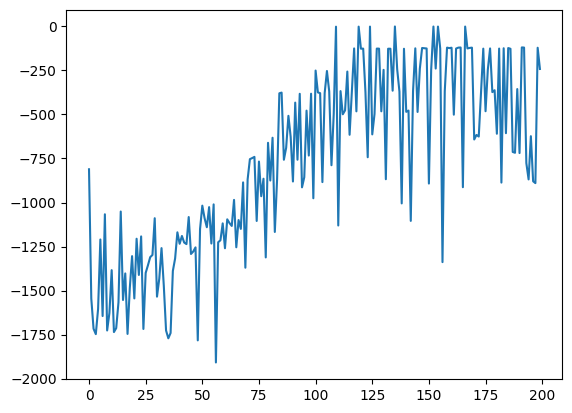

In [22]:
pendulum = gym.make("Pendulum-v1")
agent = DDPGAgent(pendulum.observation_space, pendulum.action_space)
rewards = simulate(pendulum, agent, verbose=True)

plt.plot(rewards)
plt.show()

In [23]:
pendulum = gym.make("Pendulum-v1", render_mode="human")
rewards = simulate(pendulum, agent, nb_episodes=1, verbose=False)[0]
print("Total rewards:", rewards)
pendulum.close()

Total rewards: -466.920602198616


## <div id="sac"></div>Soft Actor-critic (SAC)

Let's now focus on a stochastic algorithm: Soft Actor-Critic. This algorithm is more or less the direct application of the Policy Gradient Theorem as we wrote it in the beginning of this notebook, with an additional entropy term to encourage exploration.

### Stochastic actor implementation

Compared to DDPG, the actor in SAC is stochastic, i.e. it outputs a probability distribution over all the actions. We usually achieve this by making the actor outputs a vector of size $(n, 2)$ (with $n$ the dimension of the action space) corresponding to the mean and standard deviation of a Gaussian distribution for each action dimension.
As we need the standard deviation to be positive, we usually interpret the actor output as the $\textrm{log}$ of the standard deviation:
$$\forall k \in [1; n], a_k \sim \mathcal{N}(\mu_k, \sigma_k)$$
$$\textrm{ with } (\mu_k, \log{\sigma_k}) = \pi_k(s)$$

To select an action from our policy, we can then sample it from the resulting multi-dimensional normal distribution.
However, sampling directly the action would prevent any gradient propagation as sampling is not a differentiable operation, so in order to keep the gradient flow we use the **reparameterization trick**.

The idea is simple: instead of sampling the action $a \sim \mathcal{N}(\mu, \sigma)$, we introduce a random variable $\epsilon \sim \mathcal{N}(0, 1)$ corresponding to a noise term and compute the action as $a = \mu + \epsilon \sigma$.
This reparametrization trick is already implemented in `torch` for multiple distributions (including Normal): [cf doc here](https://docs.pytorch.org/docs/stable/distributions.html#pathwise-derivative).

<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRtHJvIDnw3fZ0A2_H4hp2KKhqteU1xBmRSgw&s"></center>

When sampling our actions this way, another issue is that the normal distribution is unbounded whereas our environment action space is not.
To fix this, we can apply the `tanh` function to the sampled action to get a value between -1 and 1, and then scale it to our action space range.

However, this also changes the computation of the log probabilities of our distribution: the effect of enforcing the bounds is computed explicitely in the [Appendix C. of the SAC original paper (p.16)](https://arxiv.org/pdf/1812.05905):
<center><img src="img/SAC_bounds.png" width="60%"></center>


### Entropy term

For a random variable $X$ with a law of density $p(X)$, we define its entropy as $$\mathcal{H}(X) = -\int_{X} p(x) log (p(x))$$
Intuitively, as in the discrete case with Shannon entropy, it measures the uncertainty of a random variable: it is maximal when $X$ follows a uniform distribution and minimal when $X$ can only take a single value (i.e. $p(X)$ is a Dirac).

In addition to the stochastic actor, SAC also modifies the agent objective with the expected entropy of the policy:
$$J(\pi) = \sum_{t = 0}^{T} \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} \left[ r(s_t, a_t) + \alpha \mathcal{H}(\pi(. | s_t)) \right]$$

About $\alpha$, directly from the paper:
> The temperature parameter $\alpha$ determines the relative importance of the entropy term against the reward, and thus controls the stochasticity of the optimal policy.
> The maximum entropy objective differs from the standard maximum expected reward objective used in conventional reinforcement learning, though the conventional objective can be recovered in the limit as $\alpha \rightarrow 0$. 

The authors also describe the advantages of using such an objective term:
> This objective has a number of conceptual and practical advantages. First, the policy is incentivized to explore more widely, while giving up on clearly unpromising avenues.
> Second, the policy can capture multiple modes of nearoptimal behavior. In problem settings where multiple actions seem equally attractive, the policy will commit equal probability mass to those actions.
> Lastly, prior work has observed improved exploration with this objective

In order to apply RL to this modified objective, we adapt the definition of the Q-function to take the entropy term into account and define the **soft Q-value function** which can be computed by iteratively applying a soft Bellman operator:
$$\delta = r(s_t, a_t) + \gamma \mathbb{E}_{s_{t + 1} \sim p, a_{t + 1} \sim \pi} \left[ Q(s_{t + 1}, a_{t + 1}) - \log \pi(a_{t + 1} | s_{t + 1}) \right]$$
$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \beta \delta$$

### Implementation

Now you can see that entropy regularisation improve so much DDPG performances.

You don't need to remeber every performance improvement tricks we used in this notebook, but you should understand how DDPG and SAC works, and what are the differences between them, and between DQN and them.

In [8]:
# %load solutions/RL6_SAC.py
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

from copy import deepcopy

import gymnasium as gym
import numpy as np
import torch


class SACAgent:
    def __init__(
        self,
        state_space,
        action_space,
        actor_lr=0.001,
        critic_lr=0.002,
        gamma=0.99,
        buffer_size=100000,
        tau=0.01,
        layer1_size=64,
        layer2_size=64,
        batch_size=32,
        alpha=0.5,
    ):
        self.name = "SAC"

        assert isinstance(action_space, gym.spaces.Box)
        self.state_space = state_space
        self.action_space = action_space

        self.action_low = torch.Tensor(action_space.low)
        self.action_high = torch.Tensor(action_space.high)

        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size

        state_size = state_space.shape[0]
        nb_actions = self.action_space.shape[0]

        self.actor = (
            torch.nn.Sequential(
                torch.nn.Linear(state_size, layer1_size),
                torch.nn.ReLU(),
                torch.nn.Linear(layer1_size, layer2_size),
                torch.nn.ReLU(),
                torch.nn.Linear(layer2_size, 2 * nb_actions),
            )
            .to(device)
            .float()
        )
        self.critic = (
            torch.nn.Sequential(
                torch.nn.Linear(state_size + nb_actions, layer1_size),
                torch.nn.ReLU(),
                torch.nn.Linear(layer1_size, layer2_size),
                torch.nn.ReLU(),
                torch.nn.Linear(layer2_size, 1),
            )
            .to(device)
            .float()
        )

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.target_critic = deepcopy(self.critic)

        self.alpha = alpha

    def update_towards(self, model, other_model, tau=None):
        """Polyak update towards `other_model`."""
        if tau is None:
            tau = self.tau
        for self_param, other_param in zip(model.parameters(), other_model.parameters()):
            self_param.data.copy_(self_param.data * (1.0 - tau) + other_param.data * tau)

    def sample_action(self, state, reparameterize=False):
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).to(device)

        if len(state.shape) == 1:  # Add batch dimension
            state = state.unsqueeze(0)

        # Get actor outputs
        actor_output = self.actor(state).view(state.shape[0], -1, 2)

        # Compute action mean and std
        actions_means = actor_output[:, 0]
        actions_log_stds = torch.clamp(actor_output[:, 1], -20, 2)  # Clamp for stability
        actions_stds = torch.exp(actions_log_stds)

        # Get action distribution (cf. torch.distributions)
        actions_distribution = torch.distributions.normal.Normal(
            actions_means,
            actions_stds,
        )

        # Sample from the action distribution using the reparametrization trick if necessary
        if reparameterize:
            actions = actions_distribution.rsample()
        else:
            actions = actions_distribution.sample()

        # Bound actions to [-1, 1]
        bounded_actions = torch.tanh(actions)

        # Compute log probabilities (/!\ Don't forget the transformation term!)
        log_probs = actions_distribution.log_prob(actions)
        log_probs -= torch.log(1 - bounded_actions.pow(2) + 1e-6)
        log_probs = log_probs.sum(dim=-1)

        # Scale actions to the environment bounds
        scaled_actions = (bounded_actions + 1) / 2  # In [0, 1]
        scaled_actions = (self.action_high - self.action_low) * scaled_actions + self.action_low  # In [low, high]

        return scaled_actions, log_probs

    def get_action(self, state):
        actions, _ = self.sample_action(state, reparameterize=False)
        return actions.squeeze().cpu().detach().numpy()

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, done = self.replay_buffer.sample(
            self.batch_size
        )

        with torch.no_grad():
            # Compute a' = \pi(s') and log \pi(s')
            next_actions, next_log_probs = self.sample_action(next_states)

            # Compute Q(s', \pi(s'))
            next_q_values = self.target_critic(
                torch.cat((next_states, next_actions), -1)
            ).view(-1)

        # Compute target = r + \gamma * (1 - d) * [ Q(s', \pi(s')) - \alpha log \pi(s') ]
        td_error = rewards + self.gamma * (1 - done) * (
            next_q_values - self.alpha * next_log_probs
        )

        # Compute Q(s, a)
        q_values = self.critic(torch.cat((states, actions), 1)).view(-1)

        # Compute critic loss (TD error)
        self.critic_optimizer.zero_grad()
        critic_loss = torch.nn.functional.mse_loss(q_values, td_error)
        critic_loss.backward()
        self.critic_optimizer.step()

        self.update_towards(self.target_critic, self.critic)

        # Train actor: compute Q(s, \pi(s))
        actions, log_probs = self.sample_action(states, reparameterize=True)
        critic_values = self.critic(torch.cat((states, actions), -1)).view(-1)

        # Compute soft actor loss
        self.actor_optimizer.zero_grad()
        actor_loss = (self.alpha * log_probs.view(-1) - critic_values).mean()
        actor_loss.backward()
        self.actor_optimizer.step()


In [9]:
import gymnasium as gym

# Test our agent on LunarLander
lunar = gym.make("LunarLander-v3", continuous=True)
print(" > Training SAC")
sac_agent = SACAgent(lunar.observation_space, lunar.action_space)
sac_results = simulate(lunar, sac_agent, nb_episodes=80)

 > Training SAC
Episode   0, episode return -445.3, last 20 average: -445.3
Episode   1, episode return -358.9, last 20 average: -402.1
Episode   2, episode return -352.5, last 20 average: -385.6
Episode   3, episode return -155.2, last 20 average: -328.0
Episode   4, episode return -524.6, last 20 average: -367.3
Episode   5, episode return -139.9, last 20 average: -329.4
Episode   6, episode return -102.3, last 20 average: -296.9
Episode   7, episode return -283.7, last 20 average: -295.3
Episode   8, episode return -462.0, last 20 average: -313.8
Episode   9, episode return -317.4, last 20 average: -314.2
Episode  10, episode return -88.8, last 20 average: -293.7
Episode  11, episode return -291.3, last 20 average: -293.5
Episode  12, episode return -161.2, last 20 average: -283.3
Episode  13, episode return -139.1, last 20 average: -273.0
Episode  14, episode return -98.0, last 20 average: -261.3
Episode  15, episode return -32.8, last 20 average: -247.1
Episode  16, episode return

In [12]:
lunar = gym.make("LunarLander-v3", continuous=True, render_mode="human")
rewards = simulate(lunar, sac_agent, nb_episodes=1, verbose=False)[0]
print("Total rewards:", rewards)
lunar.close()

Total rewards: 78.70563890956649
